<a href="https://colab.research.google.com/github/SkyWaet/Coursework-third-year/blob/main/Coursework_third_year.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курсовая Работа


In [ ]:
import zipfile

#zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Coursework_third_year/new_data.zip', 'r') #Opens the zip file in read mode
#zip_ref.extractall('/new_data') #Extracts the files into the /tmp folder
#zip_ref.close()

train_zip = zipfile.ZipFile('/content/drive/MyDrive/Coursework_third_year/train.zip', 'r')
val_zip = zipfile.ZipFile('/content/drive/MyDrive/Coursework_third_year/val.zip', 'r')
test_zip = zipfile.ZipFile('/content/drive/MyDrive/Coursework_third_year/test.zip', 'r')

train_zip.extractall('/train')
val_zip.extractall('/val')
test_zipf.extractall('/test')

train_zip.close()
val_zip.close()
test_zip.close()

from shutil import copy,copyfile
copy('/content/drive/MyDrive/Coursework_third_year/SinDataset.py','/content')

'/content/SinDataset.py'

In [ ]:
from shutil import copyfile
copyfile('/content/SinDataset.py','/content/drive/MyDrive/Coursework_third_year/SinDataset.py')

FileNotFoundError: ignored

In [ ]:
import torch.optim as optim
import torch
import torch.nn.functional as F
import torch.nn as nn
import time
from torch.utils.data import DataLoader
from SinDataset import SinDataset
from torchvision import transforms
from torchvision import models
from torch.utils.data import random_split
import numpy as np

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
path = './drive/MyDrive/Coursework_third_year'
transform = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.CenterCrop(224),
     transforms.ToTensor()])
#, transforms.Normalize((0.5), (0.5))])

dataset = SinDataset(info=f'/new_data/new_data/info.csv', root_dir=f'/new_data/new_data',
                     transform=transform)
test_size = int(0.1 * len(dataset))
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size - test_size
print(train_size)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
print(train_dataset.__getitem__(1))

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print(train_loader)

65751
{'image': tensor([[[0.3998, 0.3998, 0.3998,  ..., 0.3998, 0.3998, 0.3998],
         [0.3998, 0.3998, 0.3998,  ..., 0.3998, 0.3998, 0.3998],
         [0.3998, 0.3998, 0.3998,  ..., 0.3998, 0.3998, 0.3998],
         ...,
         [0.3998, 0.3998, 0.3998,  ..., 0.3998, 0.3998, 0.3998],
         [0.3998, 0.3998, 0.3998,  ..., 0.3998, 0.3998, 0.3998],
         [0.3998, 0.3998, 0.3998,  ..., 0.3998, 0.3998, 0.3998]],

        [[0.3998, 0.3998, 0.3998,  ..., 0.3998, 0.3998, 0.3998],
         [0.3998, 0.3998, 0.3998,  ..., 0.3998, 0.3998, 0.3998],
         [0.3998, 0.3998, 0.3998,  ..., 0.3998, 0.3998, 0.3998],
         ...,
         [0.3998, 0.3998, 0.3998,  ..., 0.3998, 0.3998, 0.3998],
         [0.3998, 0.3998, 0.3998,  ..., 0.3998, 0.3998, 0.3998],
         [0.3998, 0.3998, 0.3998,  ..., 0.3998, 0.3998, 0.3998]],

        [[0.3998, 0.3998, 0.3998,  ..., 0.3998, 0.3998, 0.3998],
         [0.3998, 0.3998, 0.3998,  ..., 0.3998, 0.3998, 0.3998],
         [0.3998, 0.3998, 0.3998,  ..., 0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.int64


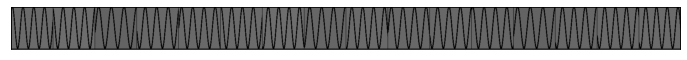

In [ ]:
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
def show_batch(dl):
    for index, elem in enumerate(dl):   
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(elem["image"], nrow=16).permute(1, 2, 0))
        print(elem["frequency"].dtype)
        break
show_batch(train_loader)

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images = batch["image"].to(self.device,non_blocking=True)
        labels = batch["frequency"].to(self.device,non_blocking=True)  
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):        
        images = batch["image"].to(self.device,non_blocking=True)
        labels = batch["frequency"].to(self.device,non_blocking=True) 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class FrequencyDetectorModel(ImageClassificationBase):
    def __init__(self,device):
        super().__init__()
        self.device = device
        self.network = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4,4), 

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4, 4), # output: 64 x 64 x 64

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 32 x 32

            #nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.MaxPool2d(2, 2), # output: 256 x 16 x 16          

            nn.Flatten(), 
            nn.Linear(3136, 1024*2),
            nn.ReLU(),
            nn.Linear(1024*2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 101),
            nn.LogSoftmax(dim=1))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for _,batch in enumerate(val_loader)]
    return model.validation_epoch_end(outputs)

def fit_old(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for _,batch in enumerate(train_loader):            
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = FrequencyDetectorModel(device).to(device)

In [ ]:
evaluate(model, val_loader)

{'val_acc': 0.009141156449913979, 'val_loss': 4.615358829498291}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.01

In [ ]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 4.7698, val_loss: 4.6228, val_acc: 0.0102
Epoch [1], train_loss: 4.6217, val_loss: 4.6214, val_acc: 0.0097
Epoch [2], train_loss: 4.6219, val_loss: 4.6227, val_acc: 0.0091


KeyboardInterrupt: ignored

In [ ]:
_,preds = torch.max(model(test_dataset[0]["image"].unsqueeze(0).to(device)),dim=1)


In [ ]:
print(test_dataset.frequencies[preds])
print(test_dataset.frequencies[0])

52.2
45.0


<h1>VGG16</h1>

In [ ]:
from torchvision import models
vgg = models.vgg16(pretrained=False)

In [ ]:
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
vgg.classifier[6] = nn.Sequential(
                      nn.Linear(4096, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 101),                   
                      nn.LogSoftmax(dim=1))

In [ ]:
vgg.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

NameError: ignored

In [ ]:

n_epochs_stop = 5
min_val_loss = np.Inf
epochs_no_improve = 0
n_epochs = 10
checkpoint_path = '/content/drive/MyDrive/Coursework_third_year/best_model.pth'

# Main loop
for epoch in range(n_epochs):
  # Initialize validation loss for epoch
  val_loss = 0
  print(f'Epoch = {epoch}')
  # Training loop
  for i,batch in enumerate(train_loader):
    # Generate predictions
    data = batch["image"].to(device)
    targets = batch["frequency"].to(device)
    out = vgg(data)
    # Calculate loss
    loss = criterion(out, targets)
    # Backpropagation
    loss.backward()
    # Update model parameters
    optimizer.step()
    
# Validation loop
  for i,batch in enumerate(val_loader):
    # Generate predictions 
    data = batch["image"].to(device)
    targets = batch["frequency"].to(device)
    out = vgg(data)
    # Calculate loss
    loss = criterion(out, targets)
    val_loss += loss

  # Average validation loss
  val_loss = val_loss / len(train_loader)

  # If the validation loss is at a minimum
  if val_loss < min_val_loss:
    # Save the model
    torch.save(vgg, checkpoint_path)
    epochs_no_improve = 0
    min_val_loss = val_loss
    
  else:
    epochs_no_improve += 1
    # Check early stopping condition
    if epochs_no_improve == n_epochs_stop:
      print('Early stopping!')
      break      
      # Load in the best model




Epoch = 0


KeyboardInterrupt: ignored

In [ ]:
best_model = torch.load('/content/drive/MyDrive/Coursework_third_year/best_model.pth')
_,preds = torch.max(best_model(test_dataset[0]["image"].unsqueeze(0).to(device)),dim=1)
preds = preds.item()


In [ ]:
succeeded = 0
for i,batch in enumerate(test_loader):
  image = batch["image"].to(device)
  frequency = batch["frequency"]
  log_ps = best_model(data)
  # Convert to probabilities
  ps = torch.exp(log_ps)
  # Find predictions and correct
  pred = torch.max(ps, dim=1)
  equals = pred == targets
  # Calculate accuracy
  accuracy = torch.mean(equals) 
print(succeeded/len(test_dataset))

TypeError: ignored

<h1>SqueezeNet</h1>

In [ ]:
sq = models.squeezenet1_0(pretrained=True)
print(sq)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
for param in sq.parameters():
    param.requires_grad = False

In [ ]:
sq.classifier[3] = nn.Sequential(
                      nn.Conv2d(1000, 101, kernel_size=(1, 1), stride=(1, 1)),
                      nn.ReLU(inplace=True),
                      nn.AdaptiveAvgPool2d(output_size=(1, 1))
                      )

In [ ]:

# Loss and optimizer


In [ ]:
sq.to(device)

In [ ]:
def fit_new(model,n_epochs,path):
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters()) 
  n_epochs_stop = 5
  min_val_loss = np.Inf
  epochs_no_improve = 0
  checkpoint_path = f'/content/drive/MyDrive/Coursework_third_year/{path}.pth'

  # Main loop
  for epoch in range(n_epochs):
    # Initialize validation loss for epoch
    val_loss = 0
    print(f'Epoch = {epoch}')
    # Training loop
    for i,batch in enumerate(train_loader):
      # Generate predictions
      data = batch["image"].to(device)
      targets = batch["frequency"].to(device)
      out = model(data)
      # Calculate loss
      loss = criterion(out, targets)
      # Backpropagation
      loss.backward()
      # Update model parameters
      optimizer.step()
      batch["image"].to('cpu')
      batch["frequency"].to('cpu')
      
  # Validation loop
    for i,batch in enumerate(val_loader):
      # Generate predictions 
      data = batch["image"].to(device)
      targets = batch["frequency"].to(device)
      out = model(data)
      # Calculate loss
      loss = criterion(out, targets)
      val_loss += loss

    # Average validation loss
    val_loss = val_loss / len(train_loader)

    # If the validation loss is at a minimum
    if val_loss < min_val_loss:
      # Save the model
      torch.save(model, checkpoint_path)
      epochs_no_improve = 0
      min_val_loss = val_loss
      
    else:
      epochs_no_improve += 1
      # Check early stopping condition
      if epochs_no_improve == n_epochs_stop:
        print('Early stopping!')
        break      
        # Load in the best model

In [ ]:
fit_new(sq,5,'sq_net')

Epoch = 0


RuntimeError: ignored

In [ ]:
_,preds = torch.max(sq(test_dataset[0]["image"].unsqueeze(0).to(device)),dim=1)
preds = preds.item()

In [ ]:
print(preds)

31


In [ ]:
print(test_dataset[0]["frequency"])

35


<h1>ResNet</h1>

In [ ]:
resnet = models.resnet152(pretrained=True)
print(resnet)

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
resnet.fc = nn.Linear(in_features=2048,out_features=101)

In [ ]:
resnet.to(device)

In [ ]:
fit_new(resnet,5,'resnet_152')

Epoch = 0
Epoch = 1
Epoch = 2
Epoch = 3
Epoch = 4


In [ ]:
_,preds = torch.max(resnet(test_dataset[0]["image"].unsqueeze(0).to(device)),dim=1)
preds = preds.item()
print(preds)
print(test_dataset[0]["frequency"])

59
15
